# Diploma
## Catching Fraud

<pre>
Student: Vladimir Nikiforov
</pre>

Payments are the most digitalized part of the financial industry, making them particularly vulnerable to digital fraud.  
The growth of mobile payments and competition for the best customer experience are pushing banks to reduce the number of verification stages.  
This reduces the effectiveness of the rule-based approach.  
Thus, banks and payment companies are moving to data analysis, machine learning, and AI-driven methods.

Modern fraud detection systems solve a wide range of analytical tasks to detect all fraudulent transactions in payment flows.

***The goal is to use the data to design an ML algorithm to identify fraudsters and conduct necessary actions.***

LOCK_USER - Current transaction is blocked and user’s account is LOCKED. This prevents the user from performing any transactions with their account. Access can only be restored after contacting an agent.  
ALERT_AGENT - Current transaction is not blocked. An alert is sent to a transaction monitoring agent for further review.

## Data
1. countries.csv
	- a table with all alpha-numeric representations of countries. You may need to use this to standardise country codes to one format
2. fraudsters.csv
	- this just holds a list of IDs of users who have been identified as fraudsters for this problem
	- there are others in the users table who are fraudsters, the challenge is to identify them as well
3. users.csv
	- a table of user data
	- **kyc** column indicates the status of the user's identity verification process
	- **terms_version** column indiciates the user's current version of the app
	- **state**
		LOCKED - the user's account is locked and they cannot perform any transactions. If there are transactions for this user, they occurred before the user was LOCKED.  

4. transactions.csv
	- all transactions conducted by users
	- **amount** and **amount_usd** is denominated in integers at the lowest unit. e.g. 5000 USD => 50 USD (because the lowest unit in USD is a cent, w/ 100 cents = 1 dollar)
	- **entry_method** is only relevant for card transactions (CARD_PAYMENT, ATM); you may ignore it for other transactions. The values are:
		misc - unknown
		chip - chip on card
		mags - magstripe on card
		manu - manual entry of card details
		cont - contactless/tap 
		mcon - special case of magstripe & contactless
	- **source** is associated with an external party we use for handling this type of transaction. (e.g. all {CARD_PAYMENT, ATM} use GAIA)
	- **type**
		P2P - sending money internally through the platform (e.g. send money without bank account)
		BANK_TRANSFER - sending money externally to a bank account
		ATM - withdrawing money from an ATM. 

	- **state** 
		COMPLETED - the transaction was completed and the user's balance was changed
		DECLINED/FAILED - the transaction was declined for some reason, usually pertains to insufficient balance 
		REVERTED - the associated transaction was completed first but was then rolled back later in time potentially due to customer reaching out to bank
        
5. currency_details.csv
	- a table with iso codes and exponents for currencies
	- exponent column can be used to convert the integer amounts in the transactions table into cash amounts. (e.g for 5000 GBP, exponent = 2, so we apply: 5000/(10^2) = 50 GBP)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import dateutil

from pprint import pprint

from scipy.stats import pearsonr
import scipy.stats as sts
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
#from sklearn.externals import joblib
import pickle

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class parameters():
    ''' Common class to store all parameters '''
    
    transaction_dataset = './data/transactions.csv'
    country_dataset = './data/countries.csv'
    currency_dataset = './data/currency_details.csv'
    fraudster_dataset = './data/fraudsters.csv'
    user_dataset = './data/users.csv'
    test_user_pkl = './data/test_users.pkl'

    random_state = 7

    n_folds = 3
    test_size = .2
    
    best_pca_components_number = None
    best_pca = None

    model_pkl = './artifacts/model.pkl'
    dataset_file_name = './data/dataset.csv'
    
    cols_to_select = ['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'CURRENCY', 'AMOUNT',
                      'STATE', 'MERCHANT_CATEGORY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'HAS_EMAIL',
                      'IS_FRAUDSTER', 'TERMS_VERSION', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE',
                      'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO']
    cat_features = ['ENTRY_METHOD', 'TYPE', 'SOURCE', 'STATE', 'MERCHANT_CATEGORY',
                    'TERMS_VERSION', 'KYC', 'CURRENCY']
    id_features = ['USER_ID','TRN_ID']
    target_feature = 'IS_FRAUDSTER'

### Check all datasets

In [4]:
def load_file(filename, encoding='windows-1251'):
    ''' Function to load csv-file and return dataframe and some statistics '''

    print(f'Loading file: {filename}')
    df = pd.read_csv(filename, encoding='windows-1251')
    print(f'Shape of the dataset: {df.shape}')
    pprint(df.describe())
    pprint(df.head())

    return df

In [5]:
trn_df = load_file(parameters.transaction_dataset)

Loading file: ./data/transactions.csv
Shape of the dataset: (688651, 11)
             AMOUNT
count  6.886510e+05
mean   3.172575e+04
std    2.304381e+06
min    0.000000e+00
25%    4.800000e+02
50%    1.420000e+03
75%    5.000000e+03
max    9.000000e+08
  CURRENCY  AMOUNT      STATE             CREATED_DATE MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED  2017-12-20 12:46:20.294              cafe   
1      EUR    2593  COMPLETED  2017-12-20 12:38:47.232               bar   
2      EUR    1077  COMPLETED  2017-12-20 12:34:39.668               NaN   
3      GBP     198  COMPLETED  2017-12-20 12:45:50.555       supermarket   
4      EUR     990  COMPLETED  2017-12-20 12:45:32.722               NaN   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              AUS         cont  ed773c34-2b83-4f70-a691-6a7aa1cb9f11   
2              CZE         cont  eb349cc1-e986-4bf4-bb75-72280a7b8680  

In [6]:
cntr_df = load_file(parameters.country_dataset)

Loading file: ./data/countries.csv
Shape of the dataset: (226, 5)
          NUMCODE    PHONECODE
count  226.000000   226.000000
mean   433.628319   531.371681
std    251.971451   648.237826
min      4.000000     0.000000
25%    219.000000   220.250000
50%    432.000000   354.500000
75%    645.250000   686.750000
max    894.000000  7370.000000
  CODE            NAME CODE3  NUMCODE  PHONECODE
0   AF     Afghanistan   AFG        4         93
1   AL         Albania   ALB        8        355
2   DZ         Algeria   DZA       12        213
3   AS  American Samoa   ASM       16       1684
4   AO          Angola   AGO       24        244


In [7]:
cur_df = load_file(parameters.currency_dataset)

Loading file: ./data/currency_details.csv
Shape of the dataset: (184, 3)
         EXPONENT
count  184.000000
mean     1.961957
std      1.189052
min      0.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      8.000000
   CCY  EXPONENT  IS_CRYPTO
0  AED         2      False
1  AFN         2      False
2  ALL         2      False
3  AMD         2      False
4  ANG         2      False


In [8]:
fraud_df = load_file(parameters.fraudster_dataset)

Loading file: ./data/fraudsters.csv
Shape of the dataset: (298, 1)
                                     USER_ID
count                                    298
unique                                   298
top     8dce5699-fa52-44a9-9aaa-ba47ca8610ee
freq                                       1
                                USER_ID
0  5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1  848fc1b1-096c-40f7-b04a-1399c469e421
2  27c76eda-e159-4df3-845a-e13f4e28a8b5
3  a27088ef-9452-403d-9bbb-f7b10180cdda
4  fb23710b-609a-49bf-8a9a-be49c59ce6de


In [9]:
user_df = load_file(parameters.user_dataset)

Loading file: ./data/users.csv
Shape of the dataset: (9944, 11)
         HAS_EMAIL   BIRTH_YEAR  FAILED_SIGN_IN_ATTEMPTS
count  9944.000000  9944.000000              9944.000000
mean      0.946702  1983.553298                 0.008045
std       0.224639    11.350379                 0.129737
min       0.000000  1927.000000                 0.000000
25%       1.000000  1978.000000                 0.000000
50%       1.000000  1986.000000                 0.000000
75%       1.000000  1992.000000                 0.000000
max       1.000000  2000.000000                 6.000000
                                     ID  HAS_EMAIL   PHONE_COUNTRY  \
0  1872820f-e3ac-4c02-bdc7-727897b60043          1  GB||JE||IM||GG   
1  545ff94d-66f8-4bea-b398-84425fb2301e          1  GB||JE||IM||GG   
2  10376f1a-a28a-4885-8daa-c8ca496026bb          1              ES   
3  fd308db7-0753-4377-879f-6ecf2af14e4f          1              FR   
4  755fe256-a34d-4853-b7ca-d9bb991a86d3          1  GB||JE||IM||GG   

  

Users for final test

In [10]:
#test_users = joblib.load(parameters.test_user_pkl)
test_users = pickle.load(open(parameters.test_user_pkl,'rb'))
print(f'Length of the list of test users: {len(test_users)}')
test_users[:5]

Length of the list of test users: 84


['0c6ec0f3-d062-4998-9ddd-5f7995164126',
 'b77d5b47-244a-41b8-8abd-62019463bd32',
 'b761cde7-d548-474f-a909-97702cdf02d9',
 'c63d1b5b-62ce-4f01-8192-9852106f663c',
 'ef4a0a80-2825-4013-98fb-09ff212912b0']

### Let's start with USERS

In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
ID                         9944 non-null object
HAS_EMAIL                  9944 non-null int64
PHONE_COUNTRY              9944 non-null object
IS_FRAUDSTER               9944 non-null bool
TERMS_VERSION              8417 non-null object
CREATED_DATE               9944 non-null object
STATE                      9944 non-null object
COUNTRY                    9944 non-null object
BIRTH_YEAR                 9944 non-null int64
KYC                        9944 non-null object
FAILED_SIGN_IN_ATTEMPTS    9944 non-null int64
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


In [12]:
# There are NaN in TERMS_VERSION - fill it by "Undefined" version
user_df['TERMS_VERSION'] = user_df['TERMS_VERSION'].fillna("Undefined")

In [13]:
user_df['IS_FRAUDSTER'].value_counts()

False    9646
True      298
Name: IS_FRAUDSTER, dtype: int64

In [14]:
# Check that we have the same users as fraudsters in two datasets
set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values).issubset(set(fraud_df['USER_ID'].values)) and set(fraud_df['USER_ID'].values).issubset(set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values))

True

In [15]:
user_df[user_df['IS_FRAUDSTER']==True].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
8166,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,1,GB||JE||IM||GG,True,Undefined,2017-09-19 01:55:22.376000,LOCKED,GB,1988,NONE,0
8167,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,0
8168,27c76eda-e159-4df3-845a-e13f4e28a8b5,1,GB||JE||IM||GG,True,2018-05-25,2018-05-11 18:20:45.608000,LOCKED,GB,1997,PASSED,0
8169,a27088ef-9452-403d-9bbb-f7b10180cdda,1,IN,True,2018-05-25,2018-05-18 16:41:12.267000,LOCKED,BE,1989,PASSED,0
8170,fb23710b-609a-49bf-8a9a-be49c59ce6de,1,LT,True,2018-03-20,2018-03-29 13:37:29.736000,LOCKED,LT,1992,PASSED,0


In [16]:
# Check that only fraudsters are locked, so we aren't longer need to have STATE of user
user_df[user_df['IS_FRAUDSTER']==True]['STATE'].value_counts()

LOCKED    298
Name: STATE, dtype: int64

In [17]:
user_df.drop('STATE', axis=1, inplace=True)

In [18]:
# Create AGE variable as age on CREATED_DATE date of profile in system
user_df['AGE'] = user_df.apply(lambda x: datetime.strptime(x['CREATED_DATE'], '%Y-%m-%d %H:%M:%S.%f').year-x['BIRTH_YEAR'], axis=1)
# We don't need BIRTH_YEAR anymore - drop it
user_df.drop('BIRTH_YEAR', axis=1, inplace=True)

In [19]:
# create binary feature that Country is in Phone_country
user_df['HOMELAND_PHONE'] = user_df.apply(lambda x: 1 if x['COUNTRY'].upper() in x['PHONE_COUNTRY'].upper().split('||') else 0, axis=1)

/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


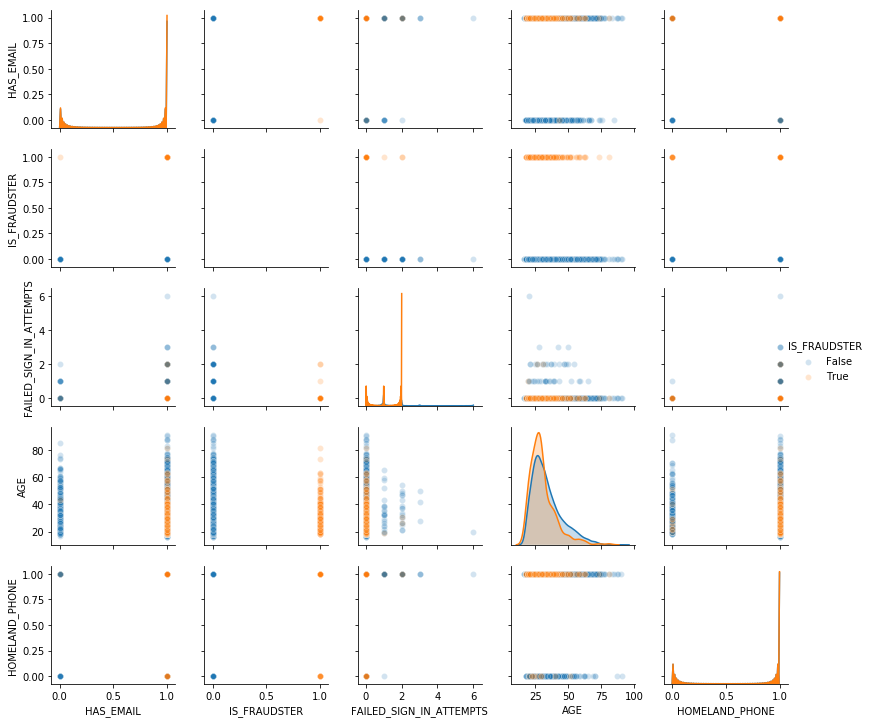

In [20]:
g=sns.pairplot(data=user_df,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)

There is one sign of fraudster in the user-dataset that fraudsters have two attempts to sign in maximum. They were probably worried about getting caught.

In [21]:
user_df[user_df['IS_FRAUDSTER']==True]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    295
2      2
1      1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

In [22]:
user_df[user_df['IS_FRAUDSTER']==False]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    9600
1      24
2      18
3       3
6       1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

So my preliminary observations for fraudsters are:

*  if country of merchant differ from country/phone_country of user
*  if currency of transaction differ from country of user
*  if period on platform is very small
*  if period between transactions is too small
*  if count of transactions is not common for this user
*  or MERCHANT_CATEGORY is not common for this user
*  or TYPE is not common for this user

*  new ideas: several bank transfers or single ATM-operation lead to LOCK
*  NAN merchant country lead to ALERT and LOCK
*  entry-method == man lead to ALERT

### Feature Engineering

#### Now look at the transactions.

In [23]:
trn_df.head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8
1,EUR,2593,COMPLETED,2017-12-20 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a
2,EUR,1077,COMPLETED,2017-12-20 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df
3,GBP,198,COMPLETED,2017-12-20 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53
4,EUR,990,COMPLETED,2017-12-20 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d


In [24]:
# look at the fraudster
trn_df[trn_df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].sort_values('CREATED_DATE', ascending=True)

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
132324,GBP,5000,COMPLETED,2018-04-06 18:43:33.955,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,961f9451-2d7d-4c62-8593-bf44d15d38b0
132344,GBP,4709,COMPLETED,2018-04-06 18:53:35.634,point_of_interest,LTU,manu,fb23710b-609a-49bf-8a9a-be49c59ce6de,CARD_PAYMENT,GAIA,953623dd-4d61-4f1a-b760-13fda4217b3b
142701,GBP,6500,COMPLETED,2018-04-09 14:53:30.372,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,eb2c9e9d-bffc-4347-9d86-28b6f0dea32d
142924,GBP,6000,COMPLETED,2018-04-09 17:23:08.928,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,P2P,INTERNAL,823e2403-eee1-4c74-beae-c53fdffdaae0


We will train model only on users with transactions:

In [25]:
trn_df = trn_df.rename({'ID': 'TRN_ID'}, axis=1)

In [26]:
df = trn_df.merge(user_df, left_on="USER_ID", right_on="ID").drop(['ID'],axis=1)
print(df.shape)
df.head()

(638742, 21)


,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE_y,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
1,GBP,175,COMPLETED,2017-12-19 12:40:55.325,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
2,GBP,220,COMPLETED,2017-12-19 12:45:05.706,department_store,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
3,GBP,210,COMPLETED,2017-12-21 07:42:25.629,NaN,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1
4,GBP,485,COMPLETED,2017-12-21 08:36:56.132,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,1,GB||JE||IM||GG,False,2018-05-25,2017-09-28 11:53:55.810000,GB,PASSED,0,55,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 21 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null object
MERCHANT_CATEGORY          208677 non-null object
MERCHANT_COUNTRY           447017 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null bool
TERMS_VERSION              638742 non-null object
CREATED_DATE_y             638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null 

In [28]:
# Replace NaN to 'Undefined' in MERCHANT_CATEGORY and MERCHANT_COUNTRY
df = df.fillna('Undefined')

In [29]:
df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: datetime.strptime(x+('000' if '.' in x else '.000000'), '%Y-%m-%d %H:%M:%S.%f'))
df['CREATED_DATE_y'] = df['CREATED_DATE_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [30]:
df['DAY_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%w')))
df['HOUR_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%H')))

In [31]:
# Create AGE variable as age on CREATED_DATE date of profile in system
df['PROFILE_AGE'] = df.apply(lambda x: (x['CREATED_DATE_x'] - x['CREATED_DATE_y']).days, axis=1)

In [32]:
# calc period of dataset to split on train/test
period = (df['CREATED_DATE_x'].max() - df['CREATED_DATE_x'].min()).days
print(f'Period of data is {period} days.')
#df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

Period of data is 940 days.


In [33]:
# No needs of CREATED_DATE_y anymore, drop them
df.drop(['CREATED_DATE_y'], axis=1, inplace=True)

In [34]:
# Transform boolean variable IS_FRAUDSTER to binary
df['IS_FRAUDSTER'] = df['IS_FRAUDSTER'].astype(int)

In [35]:
print(df.info())
print(df.describe().T)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 23 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null datetime64[ns]
MERCHANT_CATEGORY          638742 non-null object
MERCHANT_COUNTRY           638742 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null int64
TERMS_VERSION              638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null object
FAILED_SIGN_IN_ATTEMPTS    638742 

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,IS_FRAUDSTER,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,0,2018-05-25,GB,PASSED,0,55,1,3,12,83
1,GBP,175,COMPLETED,2017-12-19 12:40:55.325,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,0,2018-05-25,GB,PASSED,0,55,1,2,12,82
2,GBP,220,COMPLETED,2017-12-19 12:45:05.706,department_store,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,0,2018-05-25,GB,PASSED,0,55,1,2,12,82
3,GBP,210,COMPLETED,2017-12-21 07:42:25.629,Undefined,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,0,2018-05-25,GB,PASSED,0,55,1,4,7,83
4,GBP,485,COMPLETED,2017-12-21 08:36:56.132,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,...,0,2018-05-25,GB,PASSED,0,55,1,4,8,83


### Let's transform countries to CODE3 format

In [36]:
df['COUNTRY'] = df['COUNTRY'].map({c[0]: c[1] for c in cntr_df[['CODE','CODE3']].values})

In [37]:
# We have numeric values of MERCHANT_COUNTRY!
df['MERCHANT_COUNTRY'].value_counts()

Undefined    191725
GBR          136448
USA           42723
FRA           27673
LTU           25040
              ...  
VEN               1
NTB               1
KIO               1
482               1
319               1
Name: MERCHANT_COUNTRY, Length: 304, dtype: int64

In [38]:
# Test single example of numeric country code
cntr_df[cntr_df['PHONECODE']==386]

,CODE,NAME,CODE3,NUMCODE,PHONECODE
182,SI,Slovenia,sVN,705,386


In [39]:
# Trying to replace country code to CODE3
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values)>0 else x) if x.isdigit() else x)
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,IS_FRAUDSTER,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE
3463,EUR,10000,COMPLETED,2016-10-30 11:17:01.822,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,0,2018-03-20,gBR,PASSED,0,49,1,0,11,234
3464,EUR,9000,COMPLETED,2016-10-28 10:30:21.334,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,0,2018-03-20,gBR,PASSED,0,49,1,5,10,232
3480,EUR,6000,COMPLETED,2016-10-29 16:02:05.797,Undefined,386,chip,c069a845-b843-475e-af4f-a27e379f1c76,ATM,GAIA,...,0,2018-03-20,gBR,PASSED,0,49,1,6,16,234
9134,GBP,996,COMPLETED,2016-09-29 14:40:00.517,Undefined,000,manu,714661e3-b09b-42ef-a7b8-14a90bd455f5,CARD_PAYMENT,GAIA,...,0,2018-05-25,gBR,PASSED,0,42,1,4,14,75
9157,GBP,1068,COMPLETED,2016-10-29 16:15:53.544,Undefined,000,manu,714661e3-b09b-42ef-a7b8-14a90bd455f5,CARD_PAYMENT,GAIA,...,0,2018-05-25,gBR,PASSED,0,42,1,6,16,105


In [40]:
# Trying to replace country code to CODE3
# Add "C" to the missing countries
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values)>0 else 'C'+x) if x.isdigit() else x)
# Check that there is no any digits in country
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,...,IS_FRAUDSTER,TERMS_VERSION,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,PROFILE_AGE


In [41]:
# Fill NaN to Undefined and create binary variable HOMELAND to identify than transaction is made in country of user
df['COUNTRY'] = df['COUNTRY'].fillna('Undefined')
df['HOMELAND'] = df.apply(lambda x: 1 if x['COUNTRY'].upper() == x['MERCHANT_COUNTRY'].upper() else 0, axis=1)

#### Let's transform currency

In [42]:
df = pd.merge(df, cur_df, left_on="CURRENCY", right_on="CCY")
df['IS_CRYPTO'] = df['IS_CRYPTO'].astype(int)
df['AMOUNT'] = df['AMOUNT'] / (10**df['EXPONENT'])

In [43]:
df.columns

Index(['CURRENCY', 'AMOUNT', 'STATE', 'CREATED_DATE_x', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID', 'TYPE', 'SOURCE',
       'TRN_ID', 'HAS_EMAIL', 'PHONE_COUNTRY', 'IS_FRAUDSTER', 'TERMS_VERSION',
       'COUNTRY', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'HOMELAND_PHONE',
       'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'PROFILE_AGE', 'HOMELAND',
       'CCY', 'EXPONENT', 'IS_CRYPTO'],
      dtype='object')

In [44]:
df = df[parameters.cols_to_select]

In [45]:
df.head()

,TRN_ID,USER_ID,CREATED_DATE_x,CURRENCY,AMOUNT,STATE,MERCHANT_CATEGORY,ENTRY_METHOD,TYPE,SOURCE,...,TERMS_VERSION,KYC,FAILED_SIGN_IN_ATTEMPTS,AGE,PROFILE_AGE,HOMELAND,HOMELAND_PHONE,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,IS_CRYPTO
0,b3332e6f-7865-4d6e-b6a5-370bc75568d8,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-20 12:46:20.294,GBP,1.75,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,3,12,0
1,bf0e3adf-a932-4e3d-be9c-45d702febf03,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:40:55.325,GBP,1.75,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,82,1,1,2,12,0
2,f5e63142-4577-482a-884e-b5b8b8526872,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:45:05.706,GBP,2.20,COMPLETED,department_store,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,82,1,1,2,12,0
3,839a3fbd-ea6c-4867-ae00-9048d636c261,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 07:42:25.629,GBP,2.10,COMPLETED,Undefined,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,4,7,0
4,12974850-86c9-44e8-ac27-af0fca755dbf,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 08:36:56.132,GBP,4.85,COMPLETED,cafe,cont,CARD_PAYMENT,GAIA,...,2018-05-25,PASSED,0,55,83,1,1,4,8,0


In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AMOUNT,638742.0,185.288777,17035.825815,0.0,4.64,13.9,50.0,9000000.0
HAS_EMAIL,638742.0,0.989255,0.103098,0.0,1.00,1.0,1.0,1.0
IS_FRAUDSTER,638742.0,0.021783,0.145976,0.0,0.00,0.0,0.0,1.0
FAILED_SIGN_IN_ATTEMPTS,638742.0,0.009552,0.141177,0.0,0.00,0.0,0.0,6.0
AGE,638742.0,31.985259,9.869479,16.0,25.00,29.0,37.0,91.0
PROFILE_AGE,638742.0,219.816344,197.082166,0.0,63.00,159.0,329.0,939.0
HOMELAND,638742.0,0.293715,0.455463,0.0,0.00,0.0,1.0,1.0
HOMELAND_PHONE,638742.0,0.926347,0.261205,0.0,1.00,1.0,1.0,1.0
DAY_OF_TRANSACTION,638742.0,3.124114,1.987050,0.0,1.00,3.0,5.0,6.0
HOUR_OF_TRANSACTION,638742.0,13.123067,5.540228,0.0,9.00,13.0,17.0,23.0


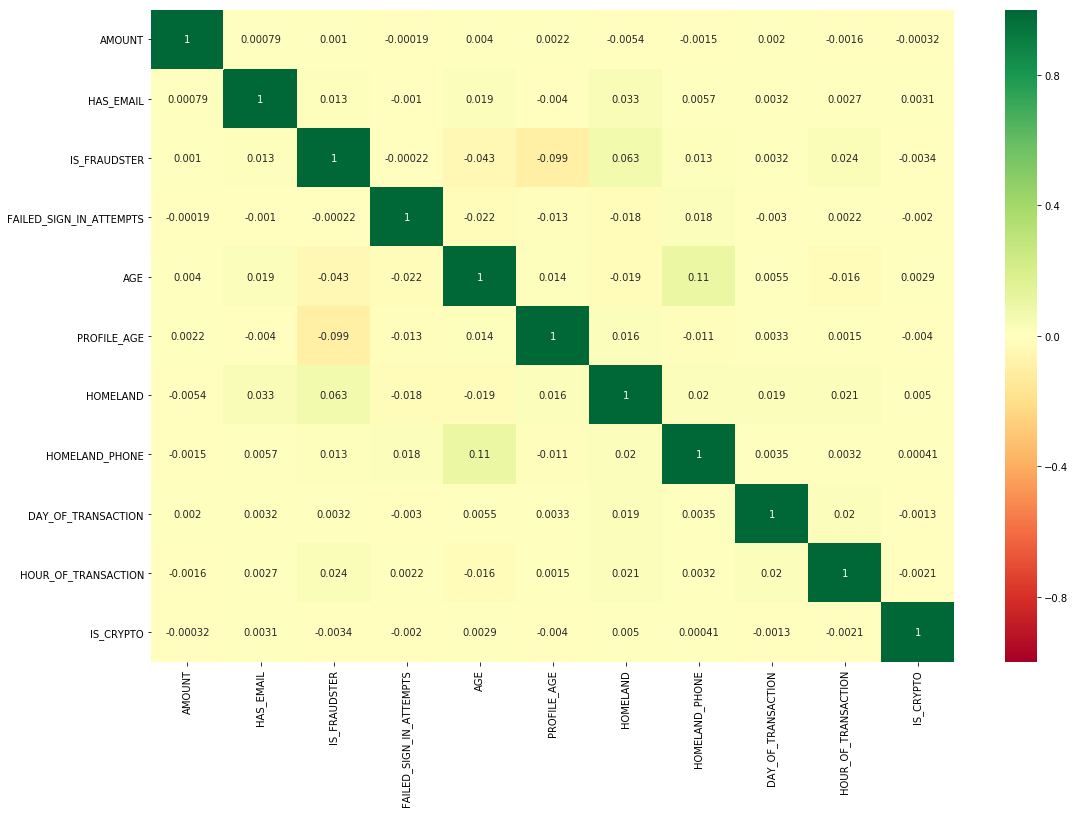

In [47]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(df.corr(),annot=True,cmap="RdYlGn",vmin=-1,vmax=1);

In [48]:
df_f = df[df['IS_FRAUDSTER']==1]
df_nof = df[df['IS_FRAUDSTER']==0]

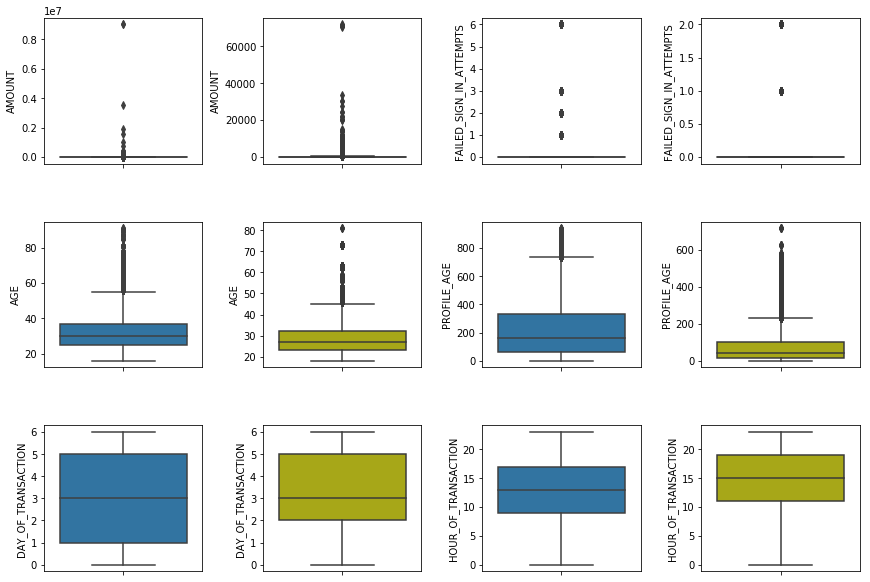

In [49]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 8))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df_nof[cols], ax=axs[index])
    index += 1
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index], color='y')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

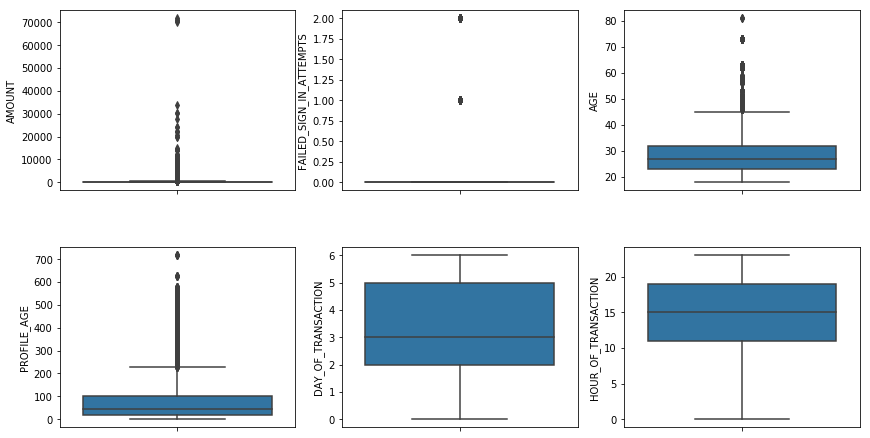

In [50]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df_f[cols].items():
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

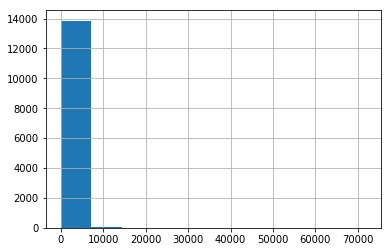

In [51]:
df[df['IS_FRAUDSTER']==1]['AMOUNT'].hist()

In [52]:
#Drop outliers
Q1 = df[['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE']].quantile(0.25)
Q3 = df[['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE']].quantile(0.75)
IQR = Q3 - Q1

In [53]:
df = df[~((df[['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE']] < (Q1 - 2.5 * IQR)) |(df[['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE']] > (Q3 + 2.5 * IQR))).any(axis=1)]

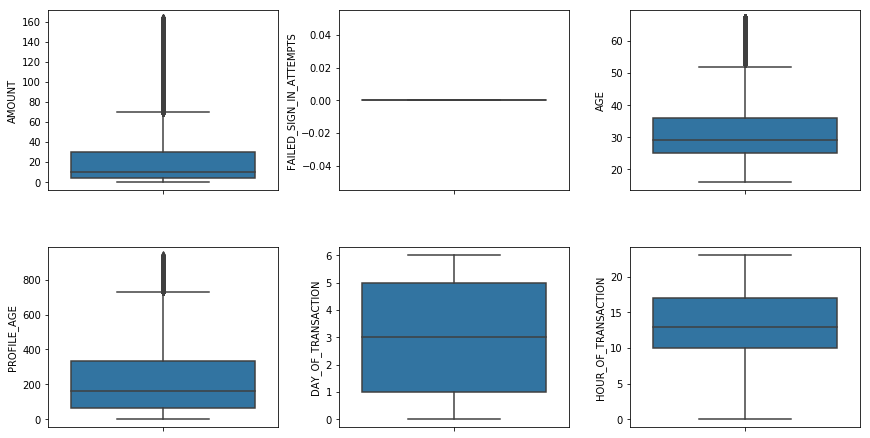

In [54]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [55]:
# store main dataset to the disk
df.to_csv(parameters.dataset_file_name, index=False)

Exclude from dataset users for final test and not train on them

In [56]:
df = df[~df['USER_ID'].isin(test_users)]

#### Join the datasets to get full dataset

In [57]:
# Let's create dummy columns for categorical variables
df = pd.get_dummies(df, columns=parameters.cat_features)

### Ok, we have final dataset. Look at it.

In [58]:
print(df.shape)
print(list(df.columns))
df.head()

(565284, 200)
['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'IS_FRAUDSTER', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'M

,TRN_ID,USER_ID,CREATED_DATE_x,AMOUNT,HAS_EMAIL,IS_FRAUDSTER,FAILED_SIGN_IN_ATTEMPTS,AGE,PROFILE_AGE,HOMELAND,...,CURRENCY_PLN,CURRENCY_QAR,CURRENCY_RON,CURRENCY_SEK,CURRENCY_SGD,CURRENCY_THB,CURRENCY_TRY,CURRENCY_USD,CURRENCY_XRP,CURRENCY_ZAR
0,b3332e6f-7865-4d6e-b6a5-370bc75568d8,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-20 12:46:20.294,1.75,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0
1,bf0e3adf-a932-4e3d-be9c-45d702febf03,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:40:55.325,1.75,1,0,0,55,82,1,...,0,0,0,0,0,0,0,0,0,0
2,f5e63142-4577-482a-884e-b5b8b8526872,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-19 12:45:05.706,2.20,1,0,0,55,82,1,...,0,0,0,0,0,0,0,0,0,0
3,839a3fbd-ea6c-4867-ae00-9048d636c261,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 07:42:25.629,2.10,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0
4,12974850-86c9-44e8-ac27-af0fca755dbf,8f99c254-7cf2-4e35-b7e4-53804d42445d,2017-12-21 08:36:56.132,4.85,1,0,0,55,83,1,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# split dataset to features and predicted value
X, y = df.drop(parameters.id_features + [parameters.target_feature], axis=1), df[parameters.target_feature]
print(list(X.columns))

['CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'MERCHANT_CATEGORY_airport', 'MERCHANT_CATEGORY_amuse

#### Classes are very unbalanced

In [60]:
df['IS_FRAUDSTER'].value_counts()

0    555059
1     10225
Name: IS_FRAUDSTER, dtype: int64

#### Let's split dataset by time to train and test datasets before changing class weights

In [61]:
# We can't split the data in respective to time (to not train on future and predict past) because we can train on user and test him!
def split_dataset(X, y, test_size=parameters.test_size, random_state=parameters.random_state):
    # Split dataset to train and test by min/max date and test_size
    max_date = max(X['CREATED_DATE_x'])
    min_date = min(X['CREATED_DATE_x'])
    date_test = max_date - timedelta(days = test_size * (max_date - min_date).days)
    test_indexes = np.array([t > date_test for t in X['CREATED_DATE_x']])
    X.drop('CREATED_DATE_x', axis=1, inplace=True)
    X_train, y_train, X_test, y_test = X[~test_indexes], y[~test_indexes], X[test_indexes], y[test_indexes]
    return X_train, X_test, y_train, y_test

In [62]:
X_train, X_test_over, y_train, y_test_over = split_dataset(X, y, test_size=parameters.test_size, random_state=parameters.random_state)

### Balancing classes in train dataset

In [63]:
# Use sample from major class with number of observations in minor class
classes_count = y_train.value_counts()
min_class_count = classes_count.min()

X_train_over = []
y_train_over = []

for cls in zip(classes_count,classes_count.index):
    if cls[0] == min_class_count:
        X_minor_class = X_train[y_train==cls[1]]
        y_minor_class = y_train[y_train==cls[1]]
    else:
        X_major_class = X_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)
        y_major_class = y_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)

del X,y
X_train_over = pd.concat([X_minor_class,X_major_class])
y_train_over = pd.concat([y_minor_class,y_major_class])
df = pd.concat([X_train_over, y_train_over], axis=1)

In [64]:
df['IS_FRAUDSTER'].value_counts()

1    3680
0    3680
Name: IS_FRAUDSTER, dtype: int64

### Do some statistical tests on balanced classes with obvious features

#### Let's test averages between groups of FRAUDSTERS and NON_FRAUDSTERS

In [65]:
# Apply scaler to normalize the dataset
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
#cols = ['AGE','PROFILE_AGE','AMOUNT','STANDART_PERIOD_HOUR']
cols = ['AGE','PROFILE_AGE','AMOUNT','DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION']
np_scaled = min_max_scaler.fit_transform(X_train_over[cols])
df_norm = pd.DataFrame(np_scaled, columns=cols)
df_norm = pd.concat([df_norm.reset_index(drop=True),y_train_over.reset_index(drop=True)], axis=1)
df_norm.head()

,AGE,PROFILE_AGE,AMOUNT,DAY_OF_TRANSACTION,HOUR_OF_TRANSACTION,IS_FRAUDSTER
0,-0.215686,-0.935397,-0.965428,0.000000,0.391304,1
1,-0.215686,-0.932705,-0.629584,0.333333,0.130435,1
2,-0.215686,-0.940781,0.234720,-0.666667,0.043478,1
3,-0.215686,-0.938089,-0.975306,-0.333333,-0.217391,1
4,-0.215686,-0.916555,-0.961106,0.000000,0.304348,1


In [66]:
# Split the dataset to fraudsters-dataset and non-fraudsters-dataset
df_fraud = df_norm[df_norm['IS_FRAUDSTER'] == 1]
df_nonfraud = df_norm[df_norm['IS_FRAUDSTER'] == 0]

In [67]:
def test_avg_diff(df1, df2, field_name, p_value_significance = .05):
    print(f'Check that average {field_name} differ between datasets...')
    p_val = sts.ttest_ind(df1[field_name], df2[field_name])[1]
    if p_val < p_value_significance:
        print(f'p-value ({p_val}) less than the level of significance ({p_value_significance}), \
which means that we can reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is different.')
    else:
        print(f'p-value ({p_val}) greater than the level of significance ({p_value_significance}), \
which means that we can''t reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is not different.')
    print('*'*80)

In [68]:
for c in cols:
    test_avg_diff(df_fraud, df_nonfraud, c)

Check that average AGE differ between datasets...
p-value (1.5535985719965051e-12) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AGE in datasets is different.
********************************************************************************
Check that average PROFILE_AGE differ between datasets...
p-value (1.4606120178551681e-183) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average PROFILE_AGE in datasets is different.
********************************************************************************
Check that average AMOUNT differ between datasets...
p-value (2.9299752114906242e-06) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AMOUNT in datasets is different.
********************************

/home/truename/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


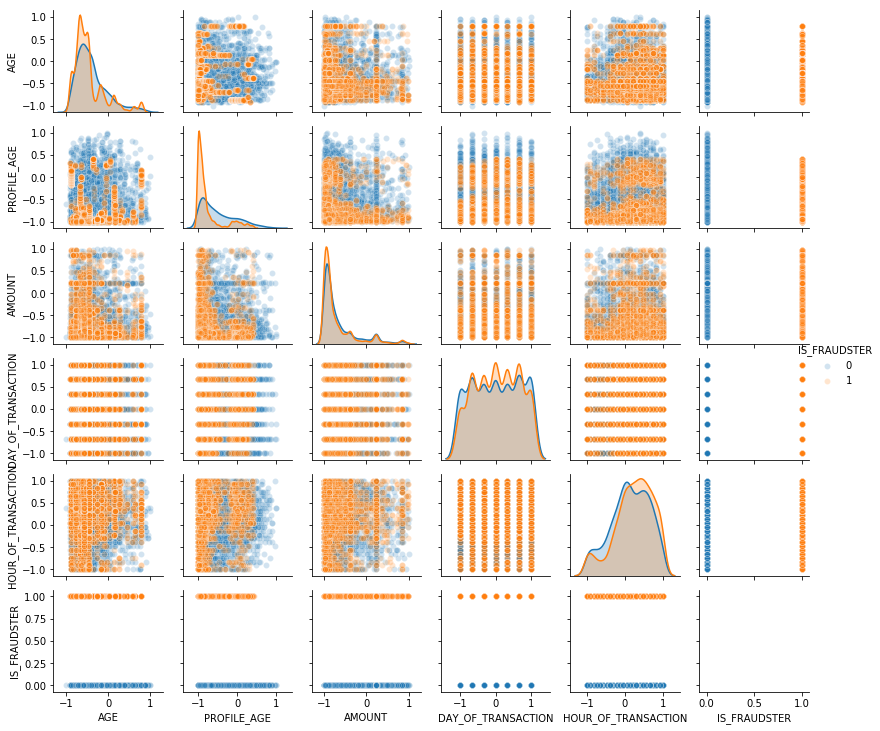

In [69]:
g=sns.pairplot(data=df_norm,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)
del df_norm

### Model Selection/Validation
#### Let's create an ML model which identifies fraudsters.

We could split task to two:
*  Solve binary classification: fraudster or not
*  Use the probabilities of binary classifier or solve multiclass classification problem with classes: 'PASS', 'LOCK_USER', 'ALERT_AGENT', 'LOCK_USER+ALERT_AGENT'

In [70]:
y_train_over.value_counts()

1    3680
0    3680
Name: IS_FRAUDSTER, dtype: int64

In [71]:
X_train_over.shape

(7360, 196)

### Baseline model - Logistic Regression

In [72]:
lm = LogisticRegression().fit(X_train_over,y_train_over)
y_train_predict = lm.predict(X_train_over)
roc_auc_train = roc_auc_score(y_train_over, y_train_predict)
print(f"ROC_AUC on train: {roc_auc_train}")

y_test_predict = lm.predict(X_test_over)

print(f"Test ROC_AUC    : {roc_auc_score(y_test_over, y_test_predict):.5f}")
print(f'Test Accuracy   : {accuracy_score(y_test_over, y_test_predict)}')
print(f'Test F1-score   : {f1_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Precision  : {precision_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Recall     : {recall_score(y_test_over, y_test_predict, average="macro")}')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC_AUC on train: 0.9017663043478261
Test ROC_AUC    : 0.78688
Test Accuracy   : 0.9302119589933211
Test F1-score   : 0.6128332724720303
Test Precision  : 0.5787388017716626
Test Recall     : 0.7868766896259293


### Random Forest

In [73]:
# train simple randomforest with KFold
rf = RandomForestClassifier(n_jobs=-1,random_state=parameters.random_state)
print(rf)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_over,y_train_over):
    X_train_fold,y_train_fold = X_train_over.iloc[trn_idx],y_train_over.iloc[trn_idx]
    X_test_fold,y_test_fold = X_train_over.iloc[tst_idx],y_train_over.iloc[tst_idx]
    rf.fit(X_train_fold,y_train_fold)
    score_on_train += rf.score(X_test_fold,y_test_fold)

rf.fit(X_train_over,y_train_over)
print(f'Score on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
print(f'Score on test : {rf.score(X_test_over,y_test_over)}')

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score on train by 3 folds : 0.6690663584323061
Score on test : 0.9677944791384911
Test ROC_AUC   : 0.75378
Test Accuracy  : 0.96779
Test F1-score  : 0.68715
Test Precision : 0.64988
Test Recall    : 0.75378


In [74]:
%%time
params = {'n_estimators':[10,20,50,100],
          'max_depth':[5,10,15,20,25,30],
          'min_samples_leaf':[1,5,10],
          'min_samples_split' : [2,10,100],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]
         }

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)
rf = rf_grid.best_estimator_

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.78125
Test Accuracy  : 0.95575
Test F1-score  : 0.66118
Test Precision : 0.61711
Test Recall    : 0.78125
CPU times: user 16.6 s, sys: 2.26 s, total: 18.8 s
Wall time: 1min 7s


In [75]:
# store list of features to the model parameter
rf.feature_names = list(X_train_over.columns.values)
# save model to artifact
#joblib.dump(rf, parameters.model_pkl)
pickle.dump(rf, open(parameters.model_pkl, 'wb'))
#rf = joblib.load(model_pkl)

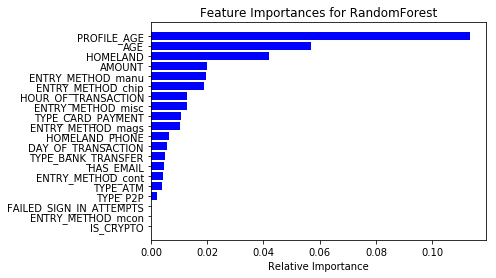

In [76]:
# Let's look at features importance
features = X_train_over.columns
importances = rf.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for RandomForest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
del rf

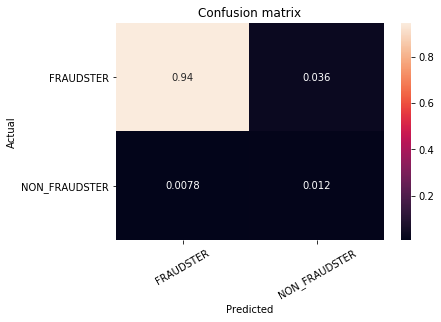

In [77]:
df_conf = pd.DataFrame({'y_Actual': y_test_over, 'y_Predicted': rf_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_conf['y_Actual'], df_conf['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_gr = confusion_matrix/sum(sum(confusion_matrix.values))
class_names = ['FRAUDSTER','NON_FRAUDSTER']
ax=sns.heatmap(confusion_matrix_gr, annot=True);
ax.set_title('Confusion matrix')
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=30);

In [78]:
confusion_matrix

Predicted,0,1
Actual,,
0,317621,12267
1,2620,3925


Because of min_samples_leaf=1 we might think that classifier has been overfitting on train dataset. But TEST accuracy and F1-score are very good for RandomForest only with 10 trees.

Let's do the grid search of parameters for randomforest

In [79]:
%%time
params = {'n_estimators':[10,20],
          'max_depth':[5,10,20],
          'min_samples_leaf':[1,5,10],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 7}
CPU times: user 720 ms, sys: 61 ms, total: 781 ms
Wall time: 2.99 s


In [80]:
rf_pred = rf_grid.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.78590
Test Accuracy  : 0.94386
Test F1-score  : 0.63591
Test Precision : 0.59540
Test Recall    : 0.78590


We have no improvements on TEST after gridsearch.

## Let's try PCA to minimize number of features for model.

In [81]:
print(f'Current shape of the dataset: {X_train_over.shape}')

Current shape of the dataset: (7360, 196)


In [82]:
l_result = []
for n in range(1,df.shape[1]//2):
    pca = PCA(n_components=n, random_state=parameters.random_state)
    pc = pca.fit_transform(X_train_over)
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)
    
    rf_pca = RandomForestClassifier(n_jobs=-1, random_state=parameters.random_state)
    score_on_train = 0
    for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_pca,y_train_pca):
        X_train_fold,y_train_fold = X_train_pca.iloc[trn_idx],y_train_pca.iloc[trn_idx]
        X_test_fold,y_test_fold = X_train_pca.iloc[tst_idx],y_train_pca.iloc[tst_idx]
        rf_pca.fit(X_train_fold, y_train_fold)
        score_on_train += rf_pca.score(X_test_fold, y_test_fold)

    rf_pca.fit(X_train_pca,y_train_pca)
    print(f'Components={n}; Accuracy on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
    print(f'Components={n}; Accuracy on test : {rf_pca.score(X_test_pca,y_test_pca)}')
    y_test_predict_proba = rf_pca.predict_proba(X_test_pca)[:, 1]
    y_test_predict = rf_pca.predict(X_test_pca)
    l_result.append((n,
                     roc_auc_score(y_test_pca, y_test_predict_proba),
                     accuracy_score(y_test_pca, y_test_predict),
                     f1_score(y_test_pca, y_test_predict, average="macro")))

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=1; Accuracy on train by 3 folds : 0.6808764556805142
Components=1; Accuracy on test : 0.6990489130434783


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=2; Accuracy on train by 3 folds : 0.7043127453541208
Components=2; Accuracy on test : 0.7126358695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=3; Accuracy on train by 3 folds : 0.8231985063809598
Components=3; Accuracy on test : 0.8417119565217391


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=4; Accuracy on train by 3 folds : 0.8284634234874225
Components=4; Accuracy on test : 0.8491847826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=5; Accuracy on train by 3 folds : 0.8177638677061485
Components=5; Accuracy on test : 0.8478260869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=6; Accuracy on train by 3 folds : 0.828633491249689
Components=6; Accuracy on test : 0.8478260869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=7; Accuracy on train by 3 folds : 0.8914741785207791
Components=7; Accuracy on test : 0.9130434782608695


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=8; Accuracy on train by 3 folds : 0.8921528051487345
Components=8; Accuracy on test : 0.90625


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=9; Accuracy on train by 3 folds : 0.9070980831415851
Components=9; Accuracy on test : 0.921875


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=10; Accuracy on train by 3 folds : 0.9147418717562713
Components=10; Accuracy on test : 0.9313858695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=11; Accuracy on train by 3 folds : 0.9099872444850877
Components=11; Accuracy on test : 0.9239130434782609


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=12; Accuracy on train by 3 folds : 0.9215354946565834
Components=12; Accuracy on test : 0.9422554347826086


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=13; Accuracy on train by 3 folds : 0.9234035570386503
Components=13; Accuracy on test : 0.9408967391304348


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=14; Accuracy on train by 3 folds : 0.9261209196502956
Components=14; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=15; Accuracy on train by 3 folds : 0.9305356710423847
Components=15; Accuracy on test : 0.9463315217391305


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=16; Accuracy on train by 3 folds : 0.932745080627698
Components=16; Accuracy on test : 0.9402173913043478


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=17; Accuracy on train by 3 folds : 0.9334240534495715
Components=17; Accuracy on test : 0.9395380434782609


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=18; Accuracy on train by 3 folds : 0.9284987525767646
Components=18; Accuracy on test : 0.9381793478260869


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=19; Accuracy on train by 3 folds : 0.931556250712943
Components=19; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=20; Accuracy on train by 3 folds : 0.9324053778455625
Components=20; Accuracy on test : 0.9442934782608695


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=21; Accuracy on train by 3 folds : 0.9288392342952158
Components=21; Accuracy on test : 0.9470108695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=22; Accuracy on train by 3 folds : 0.9354621835939048
Components=22; Accuracy on test : 0.9476902173913043


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=23; Accuracy on train by 3 folds : 0.9327444747883414
Components=23; Accuracy on test : 0.9408967391304348


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=24; Accuracy on train by 3 folds : 0.9330853027007106
Components=24; Accuracy on test : 0.9408967391304348


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=25; Accuracy on train by 3 folds : 0.9330833120856816
Components=25; Accuracy on test : 0.9456521739130435


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=26; Accuracy on train by 3 folds : 0.9358020594729993
Components=26; Accuracy on test : 0.9524456521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=27; Accuracy on train by 3 folds : 0.9303672477012291
Components=27; Accuracy on test : 0.9470108695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=28; Accuracy on train by 3 folds : 0.9349521534040642
Components=28; Accuracy on test : 0.9422554347826086


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=29; Accuracy on train by 3 folds : 0.936481724682709
Components=29; Accuracy on test : 0.9436141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=30; Accuracy on train by 3 folds : 0.9378405358112509
Components=30; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=31; Accuracy on train by 3 folds : 0.9332551973660181
Components=31; Accuracy on test : 0.9456521739130435


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=32; Accuracy on train by 3 folds : 0.9356318186137739
Components=32; Accuracy on test : 0.9476902173913043


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=33; Accuracy on train by 3 folds : 0.9298579964477042
Components=33; Accuracy on test : 0.9490489130434783


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=34; Accuracy on train by 3 folds : 0.9361415891581758
Components=34; Accuracy on test : 0.9476902173913043


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=35; Accuracy on train by 3 folds : 0.9402189745770766
Components=35; Accuracy on test : 0.9442934782608695


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=36; Accuracy on train by 3 folds : 0.9354619239484663
Components=36; Accuracy on test : 0.9415760869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=37; Accuracy on train by 3 folds : 0.9349524130495027
Components=37; Accuracy on test : 0.9558423913043478


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=38; Accuracy on train by 3 folds : 0.9358017998275608
Components=38; Accuracy on test : 0.9470108695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=39; Accuracy on train by 3 folds : 0.9391981352610795
Components=39; Accuracy on test : 0.9524456521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=40; Accuracy on train by 3 folds : 0.9332538991388253
Components=40; Accuracy on test : 0.954483695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=41; Accuracy on train by 3 folds : 0.9373308518153284
Components=41; Accuracy on test : 0.9470108695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=42; Accuracy on train by 3 folds : 0.9378395837779762
Components=42; Accuracy on test : 0.9504076086956522


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=43; Accuracy on train by 3 folds : 0.9342736133245885
Components=43; Accuracy on test : 0.9483695652173914


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=44; Accuracy on train by 3 folds : 0.934274046066986
Components=44; Accuracy on test : 0.9504076086956522


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=45; Accuracy on train by 3 folds : 0.9335935153724813
Components=45; Accuracy on test : 0.9510869565217391


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=46; Accuracy on train by 3 folds : 0.9308773644395493
Components=46; Accuracy on test : 0.9510869565217391


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=47; Accuracy on train by 3 folds : 0.9334250920313257
Components=47; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=48; Accuracy on train by 3 folds : 0.9324055509425215
Components=48; Accuracy on test : 0.9497282608695652


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=49; Accuracy on train by 3 folds : 0.9351231731996056
Components=49; Accuracy on test : 0.953125


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=50; Accuracy on train by 3 folds : 0.9349524130495027
Components=50; Accuracy on test : 0.9415760869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=51; Accuracy on train by 3 folds : 0.9349524995979822
Components=51; Accuracy on test : 0.9483695652173914


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=52; Accuracy on train by 3 folds : 0.9315569431007793
Components=52; Accuracy on test : 0.9456521739130435


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=53; Accuracy on train by 3 folds : 0.9366507538632213
Components=53; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=54; Accuracy on train by 3 folds : 0.9307059984500898
Components=54; Accuracy on test : 0.9470108695652174


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=55; Accuracy on train by 3 folds : 0.9296878421369582
Components=55; Accuracy on test : 0.9436141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=56; Accuracy on train by 3 folds : 0.9298578233507451
Components=56; Accuracy on test : 0.9436141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=57; Accuracy on train by 3 folds : 0.9327442151429027
Components=57; Accuracy on test : 0.9476902173913043


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=58; Accuracy on train by 3 folds : 0.9332538991388253
Components=58; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=59; Accuracy on train by 3 folds : 0.9298574771568271
Components=59; Accuracy on test : 0.9395380434782609


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=60; Accuracy on train by 3 folds : 0.9284987525767646
Components=60; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=61; Accuracy on train by 3 folds : 0.9256113222028527
Components=61; Accuracy on test : 0.9375


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=62; Accuracy on train by 3 folds : 0.9279895878717191
Components=62; Accuracy on test : 0.9415760869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=63; Accuracy on train by 3 folds : 0.9232334027279042
Components=63; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=64; Accuracy on train by 3 folds : 0.9281600883763833
Components=64; Accuracy on test : 0.9422554347826086


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=65; Accuracy on train by 3 folds : 0.9288389746497773
Components=65; Accuracy on test : 0.9395380434782609


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=66; Accuracy on train by 3 folds : 0.9254427257647381
Components=66; Accuracy on test : 0.9497282608695652


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=67; Accuracy on train by 3 folds : 0.9329152349384442
Components=67; Accuracy on test : 0.9368206521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=68; Accuracy on train by 3 folds : 0.9335936019209609
Components=68; Accuracy on test : 0.9415760869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=69; Accuracy on train by 3 folds : 0.9291772926562404
Components=69; Accuracy on test : 0.9483695652173914


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=70; Accuracy on train by 3 folds : 0.9284987525767647
Components=70; Accuracy on test : 0.9368206521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=71; Accuracy on train by 3 folds : 0.9273094033711325
Components=71; Accuracy on test : 0.9456521739130435


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=72; Accuracy on train by 3 folds : 0.9244223191911387
Components=72; Accuracy on test : 0.9408967391304348


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=73; Accuracy on train by 3 folds : 0.9278190008185755
Components=73; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=74; Accuracy on train by 3 folds : 0.9259512846304268
Components=74; Accuracy on test : 0.9442934782608695


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=75; Accuracy on train by 3 folds : 0.9303675073466676
Components=75; Accuracy on test : 0.9422554347826086


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=76; Accuracy on train by 3 folds : 0.9295179474716506
Components=76; Accuracy on test : 0.9368206521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=77; Accuracy on train by 3 folds : 0.929517687826212
Components=77; Accuracy on test : 0.9375


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=78; Accuracy on train by 3 folds : 0.9312158555429715
Components=78; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=79; Accuracy on train by 3 folds : 0.9278198663033708
Components=79; Accuracy on test : 0.9436141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=80; Accuracy on train by 3 folds : 0.9301984781661554
Components=80; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=81; Accuracy on train by 3 folds : 0.9274801635212352
Components=81; Accuracy on test : 0.9347826086956522


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=82; Accuracy on train by 3 folds : 0.9274803366181943
Components=82; Accuracy on test : 0.9436141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=83; Accuracy on train by 3 folds : 0.9308772778910698
Components=83; Accuracy on test : 0.9449728260869565


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=84; Accuracy on train by 3 folds : 0.9262910739610417
Components=84; Accuracy on test : 0.9375


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=85; Accuracy on train by 3 folds : 0.9257814765135989
Components=85; Accuracy on test : 0.9327445652173914


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=86; Accuracy on train by 3 folds : 0.9278186546246574
Components=86; Accuracy on test : 0.9422554347826086


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=87; Accuracy on train by 3 folds : 0.9266314691310136
Components=87; Accuracy on test : 0.9442934782608695


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=88; Accuracy on train by 3 folds : 0.9262911605095213
Components=88; Accuracy on test : 0.9395380434782609


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=89; Accuracy on train by 3 folds : 0.9279895013232397
Components=89; Accuracy on test : 0.9456521739130435


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=90; Accuracy on train by 3 folds : 0.9235735382524374
Components=90; Accuracy on test : 0.936141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=91; Accuracy on train by 3 folds : 0.9247624547156718
Components=91; Accuracy on test : 0.9415760869565217


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=92; Accuracy on train by 3 folds : 0.9273100092104891
Components=92; Accuracy on test : 0.936141304347826


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=93; Accuracy on train by 3 folds : 0.931216634479287
Components=93; Accuracy on test : 0.9429347826086957


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=94; Accuracy on train by 3 folds : 0.9189887190980818
Components=94; Accuracy on test : 0.9341032608695652


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=95; Accuracy on train by 3 folds : 0.920686367523964
Components=95; Accuracy on test : 0.9408967391304348


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=96; Accuracy on train by 3 folds : 0.9251018978523687
Components=96; Accuracy on test : 0.9368206521739131


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Components=97; Accuracy on train by 3 folds : 0.9266309498401363
Components=97; Accuracy on test : 0.9456521739130435


In [83]:
# Sort by ROC_AUC and F1-score on Test
l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
l_result

[(37, 0.9886956890949907, 0.9558423913043478, 0.9558423709250072),
 (49, 0.988402166528828, 0.953125, 0.9531249783665462),
 (39, 0.9878954247400755, 0.9524456521739131, 0.9524455643858628),
 (26, 0.9873637612240076, 0.9524456521739131, 0.9524456521739131),
 (40, 0.9871136209239131, 0.954483695652174, 0.954483170486427),
 (27, 0.9875151376417769, 0.9470108695652174, 0.9470060759129101),
 (15, 0.9873702224125709, 0.9463315217391305, 0.9463309025138467),
 (42, 0.9869317846172022, 0.9504076086956522, 0.9504070365001369),
 (31, 0.987367453331758, 0.9456521739130435, 0.9456521739130435),
 (46, 0.9866936436672968, 0.9510869565217391, 0.951086866225459),
 (32, 0.98679702268431, 0.9476902173913043, 0.9476901932496239),
 (25, 0.9868644036507561, 0.9456521739130435, 0.9456472573465744),
 (33, 0.9863512006734405, 0.9490489130434783, 0.9490487014110833),
 (44, 0.9861093676157845, 0.9504076086956522, 0.9504075858080852),
 (48, 0.9859976813563327, 0.9497282608695652, 0.9497267759562842),
 (45, 0.9858

In [84]:
print(f'Best n_components by PCA: {l_result[0][0]}')

Best n_components by PCA: 37


In [85]:
parameters.best_pca_components_number = l_result[0][0]
parameters.best_pca = PCA(n_components=parameters.best_pca_components_number, random_state=parameters.random_state)
parameters.best_pca.fit(X_train_over);

We can see improvement on TEST with PCA.

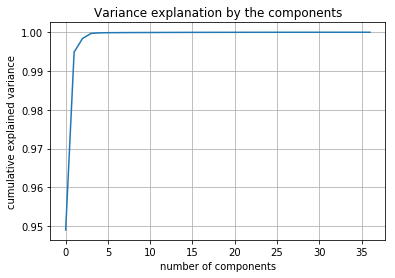

In [86]:
plt.plot(np.cumsum(parameters.best_pca.explained_variance_ratio_))
plt.title('Variance explanation by the components')
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It looks like we could use even 3 component for the good quality.  
Check it:

In [87]:
test_pca = PCA(n_components=3, random_state=parameters.random_state)
test_ds_pc = test_pca.fit_transform(X_train_over)
test_df_pc = pd.DataFrame(data = test_ds_pc, columns = ['pc'+str(i) for i in range(3)])
X_3comp_train_pca, X_3comp_test_pca, y_3comp_train_pca, y_3comp_test_pca = train_test_split(test_df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [88]:
%%time
params = {'n_estimators':[10,20,50,100],
          'max_depth':[5,10,15,20,25,30],
          'min_samples_leaf':[1,5,10],
          'min_samples_split' : [2,10,100],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]
         }

rf_3comp_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_3comp_grid.fit(X_3comp_train_pca,y_3comp_train_pca)
print(rf_3comp_grid.best_params_)

rf_3comp_pred = rf_3comp_grid.predict(X_3comp_test_pca)
print (f"Test ROC_AUC   : {roc_auc_score(y_3comp_test_pca, rf_3comp_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_3comp_test_pca,rf_3comp_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_3comp_test_pca,rf_3comp_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_3comp_test_pca,rf_3comp_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_3comp_test_pca,rf_3comp_pred,average='macro'):.5f}")

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.85054
Test Accuracy  : 0.85054
Test F1-score  : 0.85041
Test Precision : 0.85180
Test Recall    : 0.85054
CPU times: user 6.14 s, sys: 673 ms, total: 6.81 s
Wall time: 1min 1s


No so good.  
Let's return to the best component number:

In [89]:
ds_pc = parameters.best_pca.transform(X_train_over)
df_pc = pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)])
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [90]:
%%time
params = {'n_estimators':[10,20,50,100],
          'max_depth':[5,10,15,20,25,30],
          'min_samples_leaf':[1,5,10],
          'min_samples_split' : [2,10,100],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]
         }

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_pca,y_train_pca)
print(rf_grid.best_params_)

rf_pred = rf_grid.predict(X_test_pca)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.95516
Test Accuracy  : 0.95516
Test F1-score  : 0.95515
Test Precision : 0.95573
Test Recall    : 0.95516
CPU times: user 9.45 s, sys: 444 ms, total: 9.9 s
Wall time: 2min 44s


In [91]:
rf_pca = rf_grid.best_estimator_ #RandomForestClassifier(n_jobs=-1, random_state=parameters.random_state, max_depth=25, min_samples_leaf=1, n_estimators=50)
rf_pca.fit(X_train_pca,y_train_pca)
rf_pred = rf_pca.predict(X_test_pca)
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]

print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, y_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.98893
Test Accuracy  : 0.95516
Test F1-score  : 0.95515
Test Precision : 0.95573
Test Recall    : 0.95516


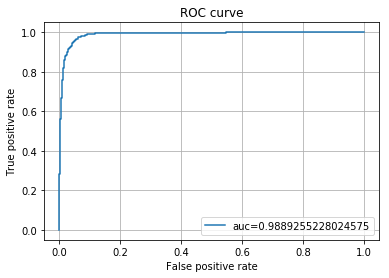

In [92]:
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]
fpr, tpr, _ = roc_curve(y_test_pca,  y_pred_proba)
auc = roc_auc_score(y_test_pca, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.legend(loc=4)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

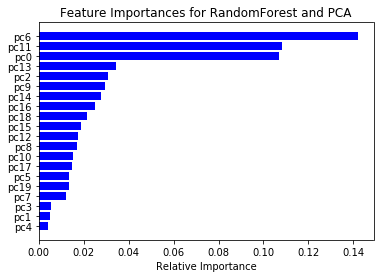

In [93]:
# Let's look at features importance
features = list(X_train_pca.columns.values)
importances = rf_pca.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for RandomForest and PCA')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

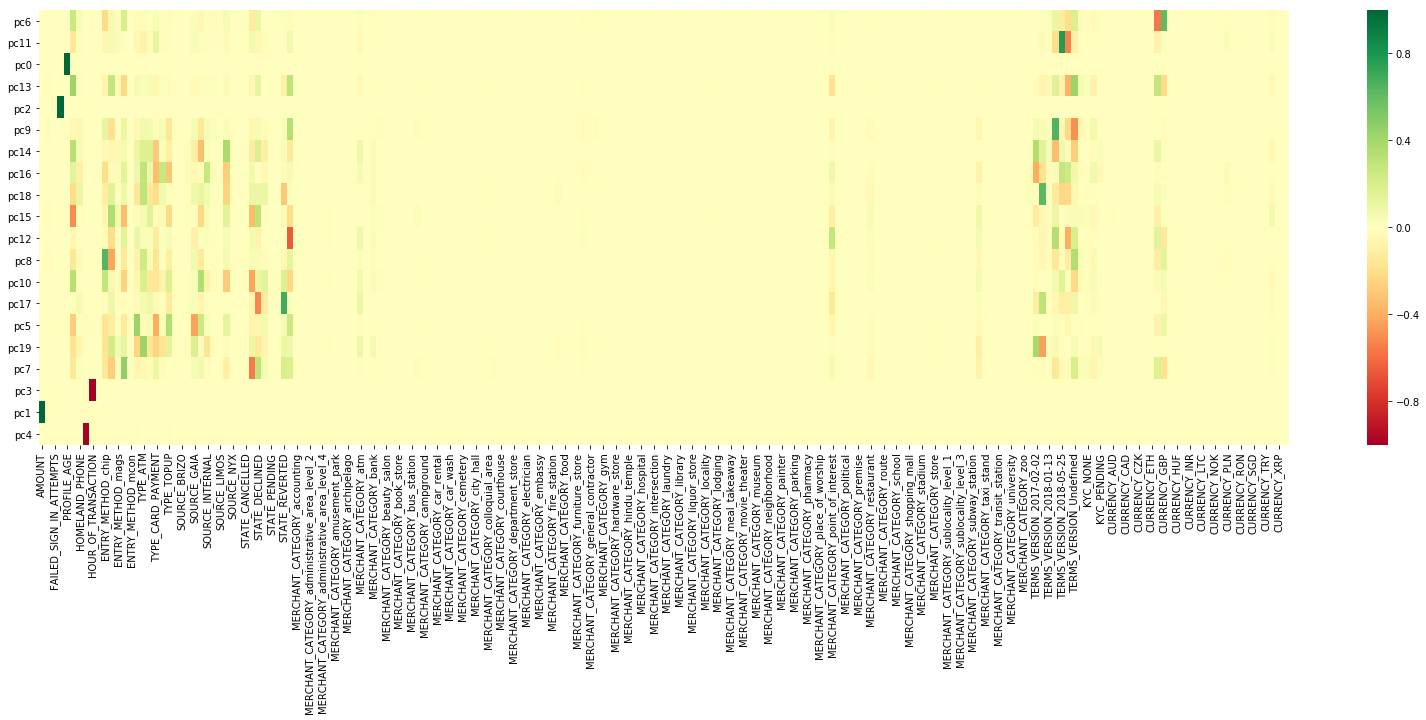

In [94]:
fig, ax = plt.subplots(figsize=(28,8))
sns.heatmap(pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc[[features[i] for i in indices[::-1]]],cmap="RdYlGn",vmin=-1,vmax=1);

Check the most important feature PC6

In [95]:
pcs = pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc['pc6']

Look at the real features inside the PC6

In [96]:
pcs.sort_values()

CURRENCY_EUR               -0.565873
ENTRY_METHOD_chip          -0.218159
TERMS_VERSION_2018-09-20   -0.202794
TERMS_VERSION_2018-05-25   -0.124603
STATE_COMPLETED            -0.116350
                              ...   
TERMS_VERSION_2018-03-20    0.107254
TERMS_VERSION_Undefined     0.194657
ENTRY_METHOD_manu           0.196439
HOMELAND                    0.262858
CURRENCY_GBP                0.612172
Name: pc6, Length: 196, dtype: float64

We see that there others most absolut weighted features inside the PC6 than in FeatureImportance of RF with real features, but there are some common.

Ok, store list of features to the model parameter and save model to artifact

In [97]:
pickle.dump(rf_pca, open(parameters.model_pkl, 'wb'))

## Operationalization
- How to utilize this model to catch fraudsters? If a fraudster is identified, what should be the resulting action: LOCK_USER, ALERT_AGENT, or BOTH?  
- Let's make a patrol-function which implements this logic. The function should accept a user_id and yield the suggested action(s) (e.g. patrol(user_id) = [‘LOCK_USER’, ‘ALERT_AGENT’])

Now we can:  
* check single transaction to be fraud transaction
* check the whole user for all his transactions

In binary classification we could use predict-proba to predict percent of probability that this is Fraudster. I think it'd be usefull to operate with three level of attention:
*  If percent is more than first level (50% for example) we need ALERT.
*  If percent is more than second level (75% for example) we need LOCK and ALERT.
*  If percent is more than max level (90% for example) we need LOCK.

In [100]:
# load our pretrained model
#rf = joblib.load(parameters.model_pkl)
rf = pickle.load(open(parameters.model_pkl,'rb'))
print('Pretrained model: ', rf)
#print('\nFeatures of this model: ', rf.feature_names)
print('\nFeatures of this model: ', list(X_train_pca.columns.values))

Pretrained model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Features of this model:  ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36']


In [101]:
# Let's look at the fraudsters
user_df = pd.read_csv(parameters.user_dataset)
user_df[user_df['IS_FRAUDSTER']==True].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
8166,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,1,GB||JE||IM||GG,True,NaN,2017-09-19 01:55:22.376000,LOCKED,GB,1988,NONE,0
8167,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,0
8168,27c76eda-e159-4df3-845a-e13f4e28a8b5,1,GB||JE||IM||GG,True,2018-05-25,2018-05-11 18:20:45.608000,LOCKED,GB,1997,PASSED,0
8169,a27088ef-9452-403d-9bbb-f7b10180cdda,1,IN,True,2018-05-25,2018-05-18 16:41:12.267000,LOCKED,BE,1989,PASSED,0
8170,fb23710b-609a-49bf-8a9a-be49c59ce6de,1,LT,True,2018-03-20,2018-03-29 13:37:29.736000,LOCKED,LT,1992,PASSED,0


In [102]:
# Test prediction from full datasets from files
# load data from files
df = pd.read_csv(parameters.dataset_file_name)[parameters.cols_to_select]

In [103]:
# Let's create dummy columns for categorical variables
df = pd.get_dummies(df, columns=parameters.cat_features)

In [104]:
ds_pc = parameters.best_pca.transform(df.drop(parameters.id_features + [parameters.target_feature] + ['CREATED_DATE_x'], axis=1))
df = pd.concat([pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)]), df[parameters.id_features + [parameters.target_feature]]], axis=1)

In [105]:
df.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc30,pc31,pc32,pc33,pc34,pc35,pc36,USER_ID,TRN_ID,IS_FRAUDSTER
0,-57.376667,-24.015270,24.920676,2.187022,0.014821,-1.060221,0.403098,-0.817134,-0.536917,-0.503842,...,-0.023871,-0.232386,0.133799,0.069860,0.067172,-0.179274,0.260091,8f99c254-7cf2-4e35-b7e4-53804d42445d,b3332e6f-7865-4d6e-b6a5-370bc75568d8,0
1,-58.376775,-24.013905,24.927095,2.199303,1.014309,-1.081341,0.396126,-0.813224,-0.539753,-0.504549,...,-0.023046,-0.234966,0.132437,0.071034,0.066224,-0.178395,0.259871,8f99c254-7cf2-4e35-b7e4-53804d42445d,bf0e3adf-a932-4e3d-be9c-45d702febf03,0
2,-58.376256,-23.563770,24.920467,2.197412,1.013964,-1.078298,0.399861,-0.800283,-0.531952,-0.491313,...,-0.015298,-0.122177,0.062645,0.041256,0.035635,-0.051553,0.000612,8f99c254-7cf2-4e35-b7e4-53804d42445d,f5e63142-4577-482a-884e-b5b8b8526872,0
3,-57.374098,-23.651643,24.842115,7.171968,-1.037312,-0.724468,0.421134,-0.631187,-0.403242,-0.138808,...,-0.008904,0.050208,-0.020740,0.035845,0.023785,0.014597,-0.007077,8f99c254-7cf2-4e35-b7e4-53804d42445d,839a3fbd-ea6c-4867-ae00-9048d636c261,0
4,-57.370937,-20.905841,24.813690,6.165780,-1.031020,-1.006961,0.436243,-0.824477,-0.552217,-0.501061,...,-0.026405,-0.232488,0.130157,0.068528,0.066884,-0.174523,0.261689,8f99c254-7cf2-4e35-b7e4-53804d42445d,12974850-86c9-44e8-ac27-af0fca755dbf,0


### 1. We can check all transactions of the same fraudster

In [106]:
X = df[df['USER_ID']=='848fc1b1-096c-40f7-b04a-1399c469e421'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[1]

In [107]:
rf.classes_, rf.predict_proba(X)

(array([0, 1]), array([[0.4997619 , 0.5002381 ],
        [0.58672727, 0.41327273],
        [0.50173626, 0.49826374],
        [0.48786752, 0.51213248],
        [0.72395516, 0.27604484]]))

So we have to use second argument of predict_proba to get the probability of being fraudster.

### 2. We can check the single transaction of fraudster

In [108]:
X = df[df['TRN_ID']=='961f9451-2d7d-4c62-8593-bf44d15d38b0'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1][0]
print(f"Probability of class IS_FRAUDSTER=1 = {y_pred}")

Probability of class IS_FRAUDSTER=1 = 0.9955555555555555


And model predicted this transaction is by fraudster!

In [109]:
# Now check another fraudster's transactions
X = df[df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99555556 0.68605808 0.96833333 0.80976537]


And model predicted that this is fraudster!

In [110]:
# look at not fraudsters
user_df[user_df['IS_FRAUDSTER']==False].head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0


In [111]:
# Now check not fraudster's transactions
X = df[df['USER_ID']=='1872820f-e3ac-4c02-bdc7-727897b60043'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.16547736 0.45151443 0.00333333 0.01538462]


And model classifying this user as not a fraudster!

### Let's build production-mode function

In [112]:
def get_user_data(user_id, asserting=False):
    # Load data from dataframe df
    result = df[df['USER_ID']==user_id].drop(parameters.id_features + [parameters.target_feature],axis=1)
    if asserting:
        assert len(result) > 0, f"We don't have data for user_id={user_id}!"
    return result

In [113]:
# Test fraudster user
X = get_user_data(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de', asserting=True)
X.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36
231458,-132.453709,23.906975,-4.313024,-4.392930,-1.821038,1.329881,0.191096,-0.611688,-0.196886,0.715106,...,-0.007115,0.204504,0.020901,0.038720,0.015227,0.033238,0.023917,0.027747,0.005290,0.016509
231459,-132.454855,20.984105,-4.296931,-4.358182,-1.867160,-1.144855,0.747426,-0.095398,-0.625452,0.561453,...,0.159551,0.034989,-0.033136,0.010716,0.017835,-0.010916,0.003939,0.005709,0.016057,0.038861
231460,-129.434482,38.911679,-4.593493,-0.389107,2.130197,1.236200,0.223777,-0.581472,-0.269132,0.710913,...,-0.015625,0.221881,0.019008,0.041744,0.004237,0.022112,0.027426,0.022873,0.014448,0.017745
231461,-129.441067,33.902743,-4.479268,-3.367043,2.156092,0.795741,0.147550,-0.529771,-0.185362,0.921902,...,-0.077800,0.186912,-0.036018,-0.012497,-0.066100,-0.070159,0.034380,0.025734,0.018874,0.054537


In [114]:
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99555556 0.68605808 0.96833333 0.80976537]


In [115]:
def check_alert(y_predicted):
    # Return the most important (heaviest by weight) flag as a result
    '''
    Rules:
        If percent is more than first level (50% for example) we need ALERT (weight=1) because it's suspicious transaction.
        If percent is more than second level (75% for example) we need LOCK and ALERT (weight=2) because it's very suspicious transaction and it's better to lock user and send alert signal to work with this user.
        If percent is more than max level (90% for example) we need LOCK (weight=3) because it's fraudster.
    '''
    
    # dictionary of alerts
    dict_of_alerts = {0: ['PASS'],
                      1: ['ALERT_AGENT'],
                      2: ['LOCK_USER', 'ALERT_AGENT'],
                      3: ['LOCK_USER']
                     }
    # for each prediction in y_prediction check the rules, get the max weight and apply dictionary to get the alert
    return dict_of_alerts[max([{       y >= .9: 3,
                                .75 <= y <  .9: 2,
                                .5  <= y < .75: 1,
                                       y <  .5: 0}[True] for y in y_predicted])]

In [116]:
check_alert(y_pred)

['LOCK_USER']

Ok, fraudster identified as fraudster and we will lock this user.

In [117]:
# Test invalid user
try:
    X = get_user_data(user_id='00000000-e3ac-4c02-bdc7-727897b60043', asserting=True)
except Exception as e:
    print(e)

We don't have data for user_id=00000000-e3ac-4c02-bdc7-727897b60043!


Ok, we raise error for invalid user_id or user_id without transactions.

In [118]:
# Test not fraudster user
X = get_user_data(user_id='1872820f-e3ac-4c02-bdc7-727897b60043', asserting=True)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.16547736 0.45151443 0.00333333 0.01538462]


In [119]:
check_alert(y_pred)

['PASS']

Ok, not-fraudster identified as not-fraudster and we will pass this user.

### Let's try to use this strategy for prediction of each transaction:
*  If percent is more than first level (50% for example) we need ALERT (weight=1) because it's suspicious transaction.
*  If percent is more than second level (75% for example) we need LOCK and ALERT (weight=2) because it's very suspicious transaction and it's better to lock user and send alert signal to work with this user.
*  If percent is more than max level (90% for example) we need LOCK (weight=3) because it's fraudster.

If we will have one or more flags for all user' transactions => return the most important (heaviest by weight) flag as a result.

In [120]:
def patrol(user_id, rf=None):
    if rf is None:
        # load our pretrained model
        from sklearn.externals import joblib
        #rf = joblib.load(parameters.model_pkl)
        rf = pickle.load(open(parameters.model_pkl,'rb'))
    # load data for user_id
    X = get_user_data(user_id = user_id, asserting=False)
    # get prediction
    if len(X) > 0:
        # if we have transactions for this user => act on them
        y_pred = rf.predict_proba(X)[:,1]
        return check_alert(y_pred)
    # if we have no transactions for this user => pass him
    return ['PASS']

In [121]:
patrol(user_id='1872820f-e3ac-4c02-bdc7-727897b60043')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['PASS']

In [122]:
patrol(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de')

['LOCK_USER']

In [124]:
# load our pretrained model
#model = joblib.load(parameters.model_pkl)
model = pickle.load(open(parameters.model_pkl,'rb'))

# check FRAUDSTER-users from users' dataset
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==True]['ID'].values}
print('Patrol-function actions on FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on FRAUDSTERS:


[LOCK_USER]                 170
[ALERT_AGENT]                73
[PASS]                       36
[LOCK_USER, ALERT_AGENT]     19
Name: ACTION, dtype: int64

**Houston, we have a problem! For FRAUDSTERS we have not only LOCKED by patrol users!**

In [128]:
# check first 1000 NON-FRAUDSTER-users (filter with transactions) from users' dataset
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==False].head(1000)['ID'].values}
print('Patrol-function actions on NON-FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on NON-FRAUDSTERS:


[PASS]                      803
[ALERT_AGENT]               111
[LOCK_USER]                  48
[LOCK_USER, ALERT_AGENT]     38
Name: ACTION, dtype: int64

**For NON-FRAUDSTERS we have ALERT_AGENT, LOCK_USER and PASS.**

Check untrained users from the presaved list

In [129]:
# Now check them
test_user_df = user_df[user_df['ID'].isin(test_users)]
test_user_df['PATROL_SOLUTION'] = test_user_df.apply(lambda x: patrol(x['ID']), axis=1)

/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [130]:
# check that fraudsters are identified as fraudsters
test_user_df[test_user_df['IS_FRAUDSTER']==True]

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,PATROL_SOLUTION


In [131]:
test_user_df['PATROL_SOLUTION'].value_counts()

[PASS]                      76
[ALERT_AGENT]                5
[LOCK_USER, ALERT_AGENT]     3
Name: PATROL_SOLUTION, dtype: int64

#### Ok, we have only NON-FRAUDSTERS and we PASS almost all of them!

## Further improvements:
*  we can group merchant_category to several big groups to minimize features in model (and possible improvements of model' accuracy), size of datasets
*  we can change rules to identify based on summary of several transactions instead of single bad transaction (to improve loyalty to users)
*  we can add feature of previous transactions - to set alert if previous transactions were bad and after them the user seems to be locked! It helps us to send alert not by level (50% for example) of probability but when we see some bad transactions in current period
* we can add features of standart day and hour of each user, stardart period from previous transaction to the current
* we can modify model to identify fraudsters without transactions

In [267]:
def ml_predict_catching_fraud_data(p_transaction_id, df=df, drop_columns=parameters.id_features + [parameters.target_feature]):
    ''' Get json-data by the input transaction_id '''
    # some checks
    assert p_transaction_id is not None, 'Parameter p_transaction_id couldn\'t be None!'
    assert len(p_transaction_id) > 0, ('Parameter p_transaction_id couldn\'t be zero-length!')
    # Filter dataframe by the TRN_ID
    X = df[df['TRN_ID']==p_transaction_id].drop(drop_columns,axis=1)
    data = X.to_json(orient='records')
    # Return json from pandas.dataframe
    return data

def ml_predict_catching_fraud_api(p_json_data, p_host='127.0.0.1', p_port='7441'):
    ''' Predict model-action by the input JSON '''
    # some checks
    assert p_json_data is not None, 'Parameter p_json_data couldn\'t be None!'
    assert len(p_json_data) > 0, ('Parameter p_json_data couldn\'t be zero-length!')
    # libs
    import json
    import ast
    import requests
    # full url
    url = f'http://{p_host}:{p_port}'
    # clear json for request
    data = ast.literal_eval(json.dumps(p_json_data))
    # Post request
    req = requests.post(url, data)
    # Check request status and return result
    if req.status_code == 200:
        return req.json()
    else:
        return f'Error response from the server: status_code = {req.status_code}'

In [268]:
test_json = ml_predict_catching_fraud_data('961f9451-2d7d-4c62-8593-bf44d15d38b0')
test_json

'[{"pc0":-132.4537088991,"pc1":23.9069752413,"pc2":-4.3130240921,"pc3":-4.3929295845,"pc4":-1.8210378034,"pc5":1.3298811371,"pc6":0.191096318,"pc7":-0.6116878408,"pc8":-0.1968860537,"pc9":0.7151061651,"pc10":-0.3549136297,"pc11":-0.1460732538,"pc12":0.2854419859,"pc13":-0.0351717793,"pc14":0.0621614226,"pc15":0.1294242791,"pc16":-0.2472887561,"pc17":-0.1678900575,"pc18":-0.320031598,"pc19":0.0609354221,"pc20":-0.3986248723,"pc21":-0.0779848935,"pc22":0.0600801355,"pc23":-0.1383980383,"pc24":-0.4205490863,"pc25":-0.2671511684,"pc26":0.0106348906,"pc27":-0.0071147181,"pc28":0.2045036641,"pc29":0.0209013339,"pc30":0.0387195189,"pc31":0.0152274207,"pc32":0.033238404,"pc33":0.0239170012,"pc34":0.0277473495,"pc35":0.0052902787,"pc36":0.0165091078}]'

Call API from the python

In [270]:
ml_predict_catching_fraud_api(p_json_data=test_json)

{'results': {'ACTION': ['LOCK_USER']}}

Call API thru cURL

In [271]:
!curl -s -XPOST 'http://127.0.0.1:7441/' -H 'accept-content: application/json' -d '[{"pc0":-132.4537088991,"pc1":23.9069752413,"pc2":-4.3130240921,"pc3":-4.3929295845,"pc4":-1.8210378034,"pc5":1.3298811371,"pc6":0.191096318,"pc7":-0.6116878408,"pc8":-0.1968860537,"pc9":0.7151061651,"pc10":-0.3549136297,"pc11":-0.1460732538,"pc12":0.2854419859,"pc13":-0.0351717793,"pc14":0.0621614226,"pc15":0.1294242791,"pc16":-0.2472887561,"pc17":-0.1678900575,"pc18":-0.320031598,"pc19":0.0609354221,"pc20":-0.3986248723,"pc21":-0.0779848935,"pc22":0.0600801355,"pc23":-0.1383980383,"pc24":-0.4205490863,"pc25":-0.2671511684,"pc26":0.0106348906,"pc27":-0.0071147181,"pc28":0.2045036641,"pc29":0.0209013339,"pc30":0.0387195189,"pc31":0.0152274207,"pc32":0.033238404,"pc33":0.0239170012,"pc34":0.0277473495,"pc35":0.0052902787,"pc36":0.0165091078}]'

{
  "results": {
    "ACTION": [
      "LOCK_USER"
    ]
  }
}


https://media.giphy.com/media/WUq1cg9K7uzHa/giphy.gif

https://giphy.com/gifs/cheer-cheering-11sBLVxNs7v6WA